# Sandbox for Support Distribution Aggregation #41

In [99]:
import polars as pl
import pandas as pd
import numpy as np
from functools import reduce

import importlib
import matplotlib.pyplot as plt


import AggregationManager with force reload

In [110]:
import aggregation
importlib.reload(aggregation)
from aggregation import AggregationManager

Test of basic pipeline:

In [151]:
manager = AggregationManager(
    index_cols=['time', 'entity_id'],
    target_cols=['conflict_prob', 'death_count'],
    weights=[0.3, 0.8]
)

pdf = pl.DataFrame({
    "time": [1, 1],
    "entity_id": [1, 2],
    "conflict_prob": pl.Series("conflict_prob", [[0.1, 0.2], [0.3, 0.4]], dtype=pl.List(pl.Float64)),
    "death_count": pl.Series("death_count", [[0.5, 0.6], [0.7, 0.8]], dtype=pl.List(pl.Float64))
})

pdf_pd = pd.DataFrame({
    "time": [1, 1],
    "entity_id": [1, 2],
    "conflict_prob": [[0.1, 0.2], [0.3, 0.4]],
    "death_count": [[0.5, 0.6], [0.7, 0.8]]
})

manager.add_model(pdf)
manager.add_model(pdf_pd)

print(manager.models)

ensemble_distributions = manager.aggregate_distributions("weighted", n_samples=100)

print(ensemble_distributions)

point_predictions = manager.aggregate_point_predictions()

print(point_predictions)

[shape: (2, 4)
┌──────┬───────────┬───────────────┬─────────────┐
│ time ┆ entity_id ┆ conflict_prob ┆ death_count │
│ ---  ┆ ---       ┆ ---           ┆ ---         │
│ i64  ┆ i64       ┆ list[f64]     ┆ list[f64]   │
╞══════╪═══════════╪═══════════════╪═════════════╡
│ 1    ┆ 1         ┆ [0.1, 0.2]    ┆ [0.5, 0.6]  │
│ 1    ┆ 2         ┆ [0.3, 0.4]    ┆ [0.7, 0.8]  │
└──────┴───────────┴───────────────┴─────────────┘, shape: (2, 4)
┌──────┬───────────┬───────────────┬─────────────┐
│ time ┆ entity_id ┆ conflict_prob ┆ death_count │
│ ---  ┆ ---       ┆ ---           ┆ ---         │
│ i64  ┆ i64       ┆ list[f64]     ┆ list[f64]   │
╞══════╪═══════════╪═══════════════╪═════════════╡
│ 1    ┆ 1         ┆ [0.1, 0.2]    ┆ [0.5, 0.6]  │
│ 1    ┆ 2         ┆ [0.3, 0.4]    ┆ [0.7, 0.8]  │
└──────┴───────────┴───────────────┴─────────────┘]
shape: (2, 4)
┌──────┬───────────┬───────────────────┬───────────────────┐
│ time ┆ entity_id ┆ conflict_prob     ┆ death_count       │
│ ---  ┆ ---     

## Other tests

Test with path to parquet files of actual prediction output:

In [104]:
pq_bs = pl.read_parquet("data/bittersweetsymphony.parquet")

# Convert bittersweet columns to list
pq_bs = pq_bs.with_columns(
    pl.col("pred_ln_ged_sb_dep").map_elements(lambda x: [float(x)], return_dtype=pl.List(pl.Float64))
)

pq_manager = AggregationManager(
    index_cols=['month_id', 'country_id'],
    target_cols=['pred_ln_ged_sb_dep'],
    weights=[0.4, 0.4]
)

# Add models
pq_manager.add_model(pq_bs)
pq_manager.add_model("data/fastcar.parquet")

pq_manager.models

[shape: (6_876, 3)
 ┌──────────┬────────────┬────────────────────┐
 │ month_id ┆ country_id ┆ pred_ln_ged_sb_dep │
 │ ---      ┆ ---        ┆ ---                │
 │ i64      ┆ i64        ┆ list[f64]          │
 ╞══════════╪════════════╪════════════════════╡
 │ 548      ┆ 1          ┆ [0.005641]         │
 │ 548      ┆ 2          ┆ [0.005641]         │
 │ 548      ┆ 3          ┆ [0.005641]         │
 │ 548      ┆ 4          ┆ [0.059421]         │
 │ 548      ┆ 5          ┆ [0.005641]         │
 │ …        ┆ …          ┆ …                  │
 │ 583      ┆ 242        ┆ [0.063684]         │
 │ 583      ┆ 243        ┆ [0.284445]         │
 │ 583      ┆ 244        ┆ [0.164365]         │
 │ 583      ┆ 245        ┆ [2.944532]         │
 │ 583      ┆ 246        ┆ [1.551994]         │
 └──────────┴────────────┴────────────────────┘,
 shape: (6_876, 3)
 ┌──────────┬────────────┬────────────────────┐
 │ month_id ┆ country_id ┆ pred_ln_ged_sb_dep │
 │ ---      ┆ ---        ┆ ---                │
 

In [105]:
pq_manager.aggregate_distributions("weighted", n_samples=10)

month_id,country_id,pred_ln_ged_sb_dep
i64,i64,list[f64]
548,1,"[0.005641, 0.005641, … 0.001793]"
548,2,"[0.005641, 0.005641, … 0.010542]"
548,3,"[0.005641, 0.005641, … 0.070901]"
548,4,"[0.059421, 0.059421, … 0.167927]"
548,5,"[0.005641, 0.005641, … 0.01015]"
…,…,…
582,242,"[0.08854, 0.08854, … 0.327009]"
582,243,"[0.250007, 0.250007, … 0.229127]"
582,244,"[0.096728, 0.096728, … 0.16187]"


Test with invalid dataframe:

In [63]:
pdf_test = pd.DataFrame({
    "time": [1, 1],
    "entity_id": ["dsf", "sdf"],
    "conflict_prob": [[0.5, 0.6], [0.7, 0.8]],
    "death_count": [[0.5, 0.6], [0.7, 0.8]]
})

manager.add_model(pdf_test)

TypeError: Index column 'entity_id' must be integer, got String

Test with invalid aggregation method

In [34]:
manager.aggregate_point_predictions("hello")

ValueError: Unsupported aggregation function: "hello", must be one of 'mean', 'median', 'min', 'max' or custum aggregation function of form Callable[[pl.Series], float]

Test with synthetic distributions

In [149]:
importlib.reload(aggregation)
from aggregation import AggregationManager

# manager setup
synth_manager = AggregationManager(
    index_cols=["time", "entity_id"],
    target_cols=["conflict_prob", "death_count"],
    weights=[0.3, 0.7],  # different weights
)

# --- Generate synthetic distributions ---

n_entities = 2
n_samples_per_model = 500

# Model 1 (Polars DF)
np.random.seed(42)
conflict_prob_m1 = [np.random.normal(loc=0.2, scale=0.05, size=n_samples_per_model).tolist() for _ in range(n_entities)]
death_count_m1 = [np.random.normal(loc=5, scale=2, size=n_samples_per_model).tolist() for _ in range(n_entities)]

pdf1 = pl.DataFrame({
    "time": [1, 1],
    "entity_id": [1, 2],
    "conflict_prob": pl.Series("conflict_prob", conflict_prob_m1, dtype=pl.List(pl.Float64)),
    "death_count": pl.Series("death_count", death_count_m1, dtype=pl.List(pl.Float64)),
})

# Model 2 (Pandas DF)
conflict_prob_m2 = [np.random.normal(loc=0.6, scale=0.1, size=n_samples_per_model).tolist() for _ in range(n_entities)]
death_count_m2 = [np.random.normal(loc=15, scale=3, size=n_samples_per_model).tolist() for _ in range(n_entities)]

pdf2 = pd.DataFrame({
    "time": [1, 1],
    "entity_id": [1, 2],
    "conflict_prob": conflict_prob_m2,
    "death_count": death_count_m2,
})

# add models
synth_manager.add_model(pdf1)
synth_manager.add_model(pdf2)

# --- Aggregate ---
ensemble_distributions_w = synth_manager.aggregate_distributions("weighted", n_samples=1000)
ensemble_distributions_a = synth_manager.aggregate_distributions("average", n_samples=1000)

print(ensemble_distributions_w)

point_distributions_w = synth_manager.aggregate_point_predictions("mean")
point_distributions_a = synth_manager.aggregate_point_predictions(use_weights=False)

print(point_distributions_w)

shape: (2, 4)
┌──────┬───────────┬─────────────────────────────────┬─────────────────────────────────┐
│ time ┆ entity_id ┆ conflict_prob                   ┆ death_count                     │
│ ---  ┆ ---       ┆ ---                             ┆ ---                             │
│ i64  ┆ i64       ┆ list[f64]                       ┆ list[f64]                       │
╞══════╪═══════════╪═════════════════════════════════╪═════════════════════════════════╡
│ 1    ┆ 1         ┆ [0.142851, 0.177497, … 0.63405… ┆ [2.920188, 5.827598, … 14.5818… │
│ 1    ┆ 2         ┆ [0.158452, 0.143726, … 0.64736… ┆ [4.818933, 4.355359, … 11.3146… │
└──────┴───────────┴─────────────────────────────────┴─────────────────────────────────┘
shape: (2, 4)
┌──────┬───────────┬───────────────┬─────────────┐
│ time ┆ entity_id ┆ conflict_prob ┆ death_count │
│ ---  ┆ ---       ┆ ---           ┆ ---         │
│ i64  ┆ i64       ┆ f64           ┆ f64         │
╞══════╪═══════════╪═══════════════╪═════════════╡
│ 1  

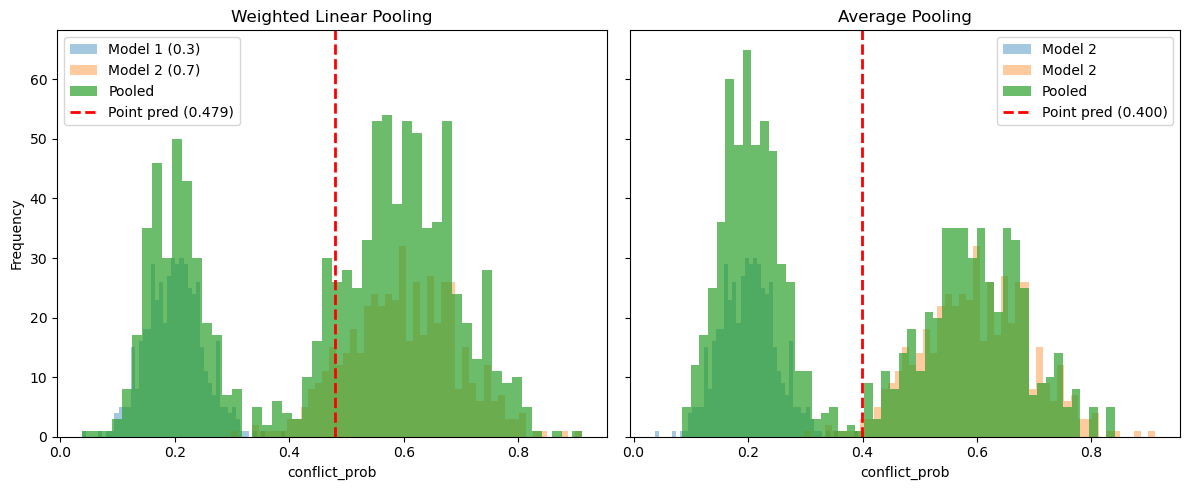

In [150]:
# Take the pooled samples for one target, one entity
pooled_weighted = ensemble_distributions_w.filter(pl.col("entity_id") == 1)["conflict_prob"][0]
pooled_average = ensemble_distributions_a.filter(pl.col("entity_id") == 1)["conflict_prob"][0]

# Take the point predictinos
point_w = point_distributions_w.filter(pl.col("entity_id") == 1)["conflict_prob"][0]
point_a = point_distributions_a.filter(pl.col("entity_id") == 1)["conflict_prob"][0]


fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Weighted pooling
axes[0].hist(conflict_prob_m1[0], bins=50, alpha=0.4, label=f"Model 1 ({synth_manager.weights[0]})")
axes[0].hist(conflict_prob_m2[0], bins=50, alpha=0.4, label=f"Model 2 ({synth_manager.weights[1]})")
axes[0].hist(pooled_weighted, bins=50, alpha=0.7, label="Pooled")
axes[0].axvline(point_w, color="red", linestyle="--", linewidth=2, label=f"Point pred ({point_w:.3f})")
axes[0].set_title("Weighted Linear Pooling")
axes[0].set_xlabel("conflict_prob")
axes[0].set_ylabel("Frequency")
axes[0].legend()

# Average pooling
axes[1].hist(conflict_prob_m1[0], bins=50, alpha=0.4, label="Model 2")
axes[1].hist(conflict_prob_m2[0], bins=50, alpha=0.4, label="Model 2")
axes[1].hist(pooled_average, bins=50, alpha=0.7, label="Pooled")
axes[1].axvline(point_a, color="red", linestyle="--", linewidth=2, label=f"Point pred ({point_a:.3f})")
axes[1].set_title("Average Pooling")
axes[1].set_xlabel("conflict_prob")
axes[1].legend()

plt.tight_layout()
plt.show()